<table width='100%'>
<tr>
<td style='background-color:white'>
    <p align="left">
    Tareas para el curso<br>
        <b>Inteligencia Artificial</b><br>
    Semestre 2023-I
    </p>
</td>
<td style='background-color:white'>
    Tópicos avanzados en estadística<br>
    Departamento de estadística<br>
    Universidad Nacional de Colombia
</td>
</tr>
</table>

<br>
<center>
    <h1>Detección de expresiones faciales usando una CNN</h1>
</center>
<br>

<table width='100%'>
<tr> <td>
    <p align="left">
Nathaly Vergel Serrano<br> <tt>nvergel@unal.edu.co</tt>
    </p> </td> <td>
    <p align="left">
Nicolle Stefania Quintero Mota<br> <tt>nquinterom@unal.edu.co</tt>
    </p></td>
</tr>
</table>

## Librerías

In [1]:
# Librerías clásicas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os           # Manejo de directorios       
import random
import time
%matplotlib inline  

# Keras: para modelo CNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, Reshape, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
from livelossplot.tf_keras import PlotLossesCallback

# Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Para imágenes
from PIL import Image as PILImage
from IPython.display import SVG, Image
import pickle

import tensorflow as tf
print("Tensorflow version:", tf.__version__)

from tensorflow.keras.models import model_from_json

Tensorflow version: 2.9.1


## Datos

Los datos consisten en imágenes de rostros en escala de grises de 48x48 píxeles. Los rostros se han registrado automáticamente para que el rostro esté más o menos centrado y ocupe aproximadamente la misma cantidad de espacio en cada imagen. La tarea consiste en categorizar cada rostro según la emoción que se muestra en una de siete categorías (0=enojado, 1=disgusto, 2=miedo, 3=feliz, 4=triste, 5=sorpresa, 6=neutro).

Fuente: [Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data)

In [2]:
# Cargar los datos desde el csv
df = pd.read_csv('fer2013.csv')
print("Número total de imágenes:", len(df))
print("Columnas:", list(df.columns))

# Dividir entre entrenamiento y validación
train_df = df[(df['Usage'] == 'PublicTest') | (df['Usage'] == 'Training')]
val_df = df[df['Usage'] == 'PrivateTest']

Número total de imágenes: 35887
Columnas: ['emotion', 'pixels', 'Usage']


Así se ve nuestro conjunto de datos.

In [3]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Y esta es la distribución de los datos en los distintos usos que los organizadores de Kaggle asignaron.

In [4]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

## Conjunto de entrenamiento y validación
### Guardar las imágenes en carpetas por emoción

In [5]:
# Definir las emociones y los labels correspondientes en español
emociones = {0: 'Enojado',
             1: 'Asco',
             2: 'Miedo',
             3: 'Feliz',
             4: 'Triste',
             5: 'Sorpresa',
             6: 'Neutral'}

In [6]:
# Crear un nuevo dataframe solo con las filas que corresponden a imágenes de "PublicTest" y Training
df_public_test = df[(df['Usage'] == 'PublicTest') | (df['Usage'] == 'Training')]

for emotion_code, emotion_name in emociones.items():
    # Crear la carpeta si no existe
    folder_path = f"data/train/{emotion_name}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Filtrar las imágenes de la emoción actual
    emotion_images = df_public_test[df_public_test['emotion'] == emotion_code]
    
    # Iterar sobre las imágenes y guardarlas en la carpeta correspondiente
    for index, row in emotion_images.iterrows():
        pixel_data = row['pixels']
        pixels = np.array(pixel_data.split(), dtype=np.uint8).reshape((48, 48))
        image = PILImage.fromarray(pixels, mode='L')
        image_path = os.path.join(folder_path, f"train_{index}.jpg")
        image.save(image_path)

In [7]:
# Crear un nuevo dataframe solo con las filas que corresponden a imágenes de "PrivateTest"
df_private_test = df[(df['Usage'] == 'PrivateTest')]

for emotion_code, emotion_name in emociones.items():
    # Crear la carpeta si no existe
    folder_path = f"data/test/{emotion_name}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Filtrar las imágenes de la emoción actual
    emotion_images = df_private_test[df_private_test['emotion'] == emotion_code]
    
    # Iterar sobre las imágenes y guardarlas en la carpeta correspondiente
    for index, row in emotion_images.iterrows():
        pixel_data = row['pixels']
        pixels = np.array(pixel_data.split(), dtype=np.uint8).reshape((48, 48))
        image = PILImage.fromarray(pixels, mode='L')
        image_path = os.path.join(folder_path, f"test_{index}.jpg")
        image.save(image_path)

### Visualizar algunas de las imágenes

Vamos a imprimir algunos ejemplos de cada categoría, para hacernos una idea de cómo se ven nuestros datos.

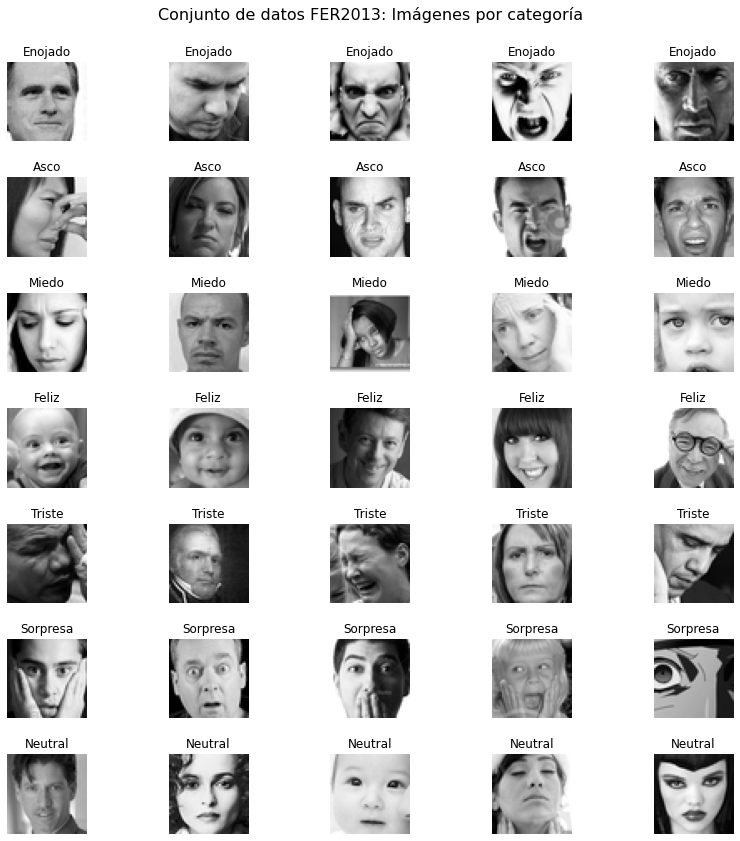

In [8]:
# Crear una cuadrícula para imprimir las fotos
fig, axes = plt.subplots(len(emociones), 5, figsize=(12, 12))
fig.suptitle('Conjunto de datos FER2013: Imágenes por categoría', fontsize=16)

# Iterar sobre cada categoría de emoción
for indice_emocion, nombre_emocion in emociones.items():
    # Obtener 5 imágenes aleatorias para la categoría de expresión/emoción actual
    imagenes_entrenamiento = train_df[train_df['emotion'] == indice_emocion].sample(5, random_state=1)['pixels']
    
    # Iterar sobre cada columna en la cuadrícula
    for indice_columna, pixels_imagen in enumerate(imagenes_entrenamiento):
        # Convertir la cadena de píxeles en un arreglo de numpy
        arreglo_pixels = np.array(pixels_imagen.split(), dtype='uint8').reshape((48, 48))
        
        # Mostrar la imagen
        axes[indice_emocion, indice_columna].imshow(arreglo_pixels, cmap='gray')
        axes[indice_emocion, indice_columna].axis('off')
        axes[indice_emocion, indice_columna].set_title(nombre_emocion)

# Ajustar el espaciado entre las filas
plt.tight_layout(pad=2.0)

# Mostrar la cuadrícula de imágenes
plt.show()

Ahora, veamos qué cantidad de imágenes tenemos por cada clase.

In [9]:
expressions = [emociones[idx] for idx in emociones]
num_samples = [len(train_df[train_df['emotion'] == idx]) for idx in emociones]

# Mostrar los resultados
for i in range(len(expressions)):
    print(expressions[i], "->", num_samples[i])

Enojado -> 4462
Asco -> 492
Miedo -> 4593
Feliz -> 8110
Triste -> 5483
Sorpresa -> 3586
Neutral -> 5572


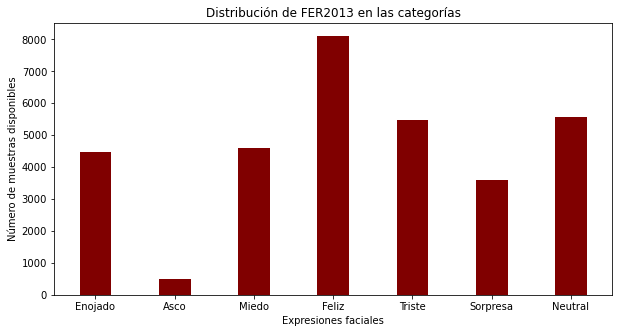

In [10]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(expressions, num_samples, color ='maroon',
        width = 0.4)
 
plt.xlabel("Expresiones faciales")
plt.ylabel("Número de muestras disponibles")
plt.title("Distribución de FER2013 en las categorías")
plt.show()

Hay una subrepresentación de la clase <code>Asco</code>. Debemos usar un método de _aumento de datos_.

## Data Augmentation

In [11]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image as PILImage

def generate_augmented_images(emotion, total_images):
    original_dir = f"data/train/{emotion}"
    augmented_dir = f"data/train/{emotion}"

    def load_image(img_path):
        img = PILImage.open(img_path)
        img = img.convert('L')
        img = img.resize((48, 48))
        img = np.array(img)
        img = img / 255.0
        img = np.expand_dims(img, axis=-1)
        return img

    if not os.path.exists(augmented_dir):
        os.makedirs(augmented_dir)

    original_images = []
    for filename in os.listdir(original_dir):
        img_path = os.path.join(original_dir, filename)
        original_images.append(img_path)

    actual_number_images = len(original_images)
    num_images = total_images - actual_number_images

    if num_images > 0:
        datagen = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        generated_images = 0
        for img_path in original_images:
            img = load_image(img_path)
            img = img.reshape((1,) + img.shape)
            save_prefix = f"augmented_{emotion}_" + os.path.splitext(os.path.basename(img_path))[0]

            i = 0
            for batch in datagen.flow(img, batch_size=1, save_to_dir=augmented_dir, save_prefix=save_prefix, save_format='jpg'):
                i += 1
                generated_images += 1
                if i >= 8:
                    break

            if generated_images >= num_images:
                break

        print("Número total de imágenes generadas:", generated_images)
    else:
        print("No es necesario generar imágenes adicionales")
    
    
def delete_random_images(emotion, num_images_to_keep):
    # Construir la ruta del directorio basándose en el nombre de la emoción
    emotion_dir = os.path.join("data/train", emotion)

    # Obtener la lista de imágenes en el directorio
    image_files = os.listdir(emotion_dir)

    # Verificar si hay más imágenes de las necesarias
    if len(image_files) > num_images_to_keep:
        # Calcular cuántas imágenes eliminar
        num_images_to_delete = len(image_files) - num_images_to_keep

        # Seleccionar aleatoriamente las imágenes a eliminar
        images_to_delete = random.sample(image_files, num_images_to_delete)

        # Eliminar las imágenes seleccionadas
        for image_file in images_to_delete:
            image_path = os.path.join(emotion_dir, image_file)
            os.remove(image_path)

        print(f"Eliminadas {num_images_to_delete} imágenes")
    else:
        print("No es necesario eliminar imágenes")

In [12]:
generate_augmented_images(emotion = "Miedo", total_images = 5300)
generate_augmented_images(emotion = "Asco", total_images = 5000)
delete_random_images(emotion = "Feliz", num_images_to_keep = 5000)

Número total de imágenes generadas: 712
Número total de imágenes generadas: 3936
Eliminadas 3110 imágenes


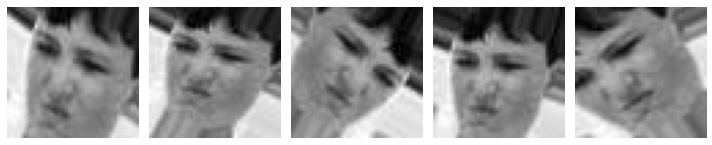

In [13]:
# Directorio que contiene las imágenes de "disgust"
disgust_dir = "data/train/Asco"

# Obtener la lista de nombres de archivo de las imágenes de "disgust"
image_files = sorted([f for f in os.listdir(disgust_dir) if f.startswith('augmented')])

# Crear una figura para mostrar las imágenes
fig = plt.figure(figsize=(10, 10))

# Imprimir las primeras cinco imágenes
for i in range(5):
    img_path = os.path.join(disgust_dir, image_files[i])
    
    # Cargar la imagen
    img = plt.imread(img_path)
    
    # Agregar la imagen a la figura
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(img, cmap='gray')
    ax.axis('off')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

In [14]:
expressions, num_samples = [], []

for expression in os.listdir("data/train/"):
    expressions.append(expression)
    num_samples.append(len(os.listdir("data/train/" + expression)))
    print(str(len(os.listdir("data/train/" + expression)))+ " imágenes de " + expression)

4428 imágenes de Asco
4462 imágenes de Enojado
5000 imágenes de Feliz
5304 imágenes de Miedo
5572 imágenes de Neutral
3586 imágenes de Sorpresa
5483 imágenes de Triste


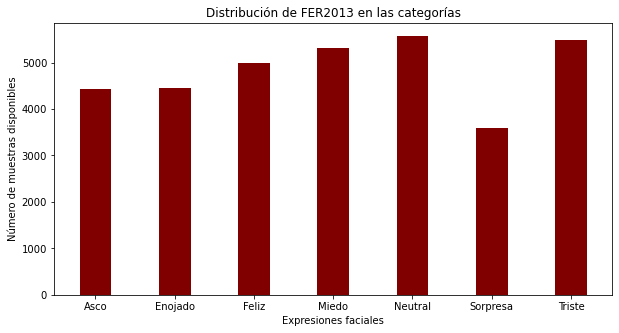

In [15]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(expressions, num_samples, color ='maroon',
        width = 0.4)
 
plt.xlabel("Expresiones faciales")
plt.ylabel("Número de muestras disponibles")
plt.title("Distribución de FER2013 en las categorías")
plt.show()

## Generar los datos para el entrenamiento y la validación

Vamos a dividir el conjunto de datos de tal manera que el 80% de los datos sea usado en el entrenamiento y 20% en validación. 

Durante el entrenamiento, vamos a intentar minimizar la función de pérdida de la red neuronal usando <code>mini-batch gradient descent</code>. 

Este algoritmo funciona dividiendo el conjunto de datos de entrenamiento en lotes más pequeños de datos, y luego actualizando los pesos del modelo en función del gradiente promedio de cada lote. Este enfoque permite que el modelo haga actualizaciones más frecuentes de los pesos, lo que puede ayudar a que converja más rápido y evitar que se atasque en mínimos locales.

Adicionalmente, vamos a usar la función <code>ImageDataGenerator</code> de Keras. Ésta toma como entrada un conjunto de imágenes y puede aplicar una serie de transformaciones como rotación, zoom, volteo horizontal o vertical, ajuste de brillo y contraste, normalización, y más, como técnicas de aumentación de datos.

In [16]:
img_size = 48    # Las imágenes son de 48x48 pixeles
batch_size = 64

# Girar horizontamente algunas imágenes (seleccionadas aleatoriamente)
datagen_train      = ImageDataGenerator(horizontal_flip=True)
datagen_validation = ImageDataGenerator(horizontal_flip=True)

# Generar los datos de entrenamiento
train_generator = datagen_train.flow_from_directory("data/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

# Generar los datos de validación
validation_generator = datagen_validation.flow_from_directory("data/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 33835 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


## Modelo CNN

Las redes neuronales convolucionales (CNN) están diseñadas específicamente para problemas de clasificación de imágenes, por lo que serán especialmente útiles en nuestra tarea de reconocer expresiones faciales. Algunas ventajas que presentan este tipo de redes son:
>_Capacidad para extraer características:_ las CNN son capaces de extraer automáticamente características útiles de las imágenes. En el caso del reconocimiento de expresiones faciales, una CNN puede aprender a identificar los rasgos faciales que indican una emoción específica, como las arrugas alrededor de los ojos para una sonrisa o el ceño fruncido para la ira.

>_Robustez a la variación:_ las expresiones faciales pueden variar ampliamente entre individuos, lo que dificulta la identificación de características comunes. Sin embargo, las CNN pueden aprender a reconocer características comunes en diferentes imágenes y pueden entrenarse para que sean resistentes a la variación en la expresión facial.

>_Uso eficiente de parámetros:_ las CNN están diseñadas para usar de manera eficiente sus parámetros para aprender características en diferentes escalas y orientaciones. Esto les permite extraer características importantes de las imágenes faciales y evitar el sobreajuste.

![](model.png)
Artículo fuente: Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

A continuación vamos a describir la red neuronal convolucional que vamos a utilizar para la clasificación de expresiones faciales, inspirada en la propuesta por Goodfellow et. al. (2013).

- La primera capa de la red es una capa convolucional 2D con 64 filtros de tamaño 3x3, con <code>padding = "same"</code> para garantizar que la salida tenga las mismas dimensiones que la entrada y no perdamos información. La forma de entrada se establece en (48, 48, 1), lo que significa que la red espera imágenes en escala de grises de tamaño 48x48 píxeles. Después de la capa convolucional, se agrega una capa de normalización de lotes para normalizar las activaciones de la capa anterior (se usa como técnica de regularización para mejorar la estabilidad y convergencia del modelo). Luego, se aplica una función de activación lineal rectificada (ReLU) para introducir no linealidad. Se agrega una capa de MaxPooling para reducir las dimensiones espaciales de la salida, seguida de una capa de eliminación aleatoria (dropout) para evitar el sobreajuste, apagando el 25% de las neuronas.

- Las siguientes tres capas son similares a la primera capa, con un número creciente de filtros (128, 512 y 512) y diferentes tamaños de kernel (5x5, 3x3 y 3x3). Se repite el mismo patrón de capas de normalización de lotes, activación ReLU, agrupación máxima y capas de eliminación aleatoria después de cada capa convolucional.

- Después de la última capa convolucional, se agrega una capa de aplanamiento para convertir los mapas de características 2D en un vector de características 1D.

- Se agregan dos capas completamente conectadas con 256 y 512 unidades respectivamente después de la capa de aplanamiento. Nuevamente, se agregan capas de normalización de lotes, activación ReLU y eliminación aleatoria después de cada capa completamente conectada para regularizar el modelo y evitar el sobreajuste.

- Finalmente, se agrega una capa de salida densa con 7 unidades y una función de activación softmax para predecir la probabilidad de cada una de las 7 posibles expresiones faciales.
- El optimizador Adam con una tasa de aprendizaje de 0,0005 se utiliza para entrenar el modelo. La función de pérdida es la _entropía cruzada categórica_ y la métrica de rendimiento es la precisión.

__Filtro Vs. Kernel:__ Un filtro es una matriz que se desliza por la imagen de entrada para producir o detectar una característica de salida. El término kernel, por otro lado, se refiere a un _conjunto de filtros_ que se aplican a una imagen de entrada para producir una variedad de características de salida.

__Entropía cruzada categórica:__ Es una función de pérdida que se utiliza en el entrenamiento de modelos de aprendizaje automático, especialmente en problemas de clasificación de varias clases.
$$
H\left(y_{\text {true }}, y_{\text {pred }}\right)=-\sum_{i=1}^C y_{\text {true, i}} \log \left(y_\text{pred, i}\right)
$$
Donde:
- C es el número de clases en el problema de clasificación.
- $y_{\text{true}}$ es la distribución de probabilidad real de las clases.
- $y_{\text{pred}}$ es la distribución de probabilidad predicha por el modelo.

La función de pérdida se calcula para cada clase $i$ en el problema de clasificación y se suma para todas las clases. La función de pérdida es mayor cuando la distribución de probabilidad predicha está lejos de la distribución real, y se acerca a cero cuando las distribuciones son iguales. El objetivo del entrenamiento es minimizar la entropía cruzada categórica para mejorar la precisión de la clasificación.

In [17]:
# Inicializar la CNN
model = Sequential()

# Primera convolución
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Hiperparámetro

# Segunda capa convolucional
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Tercera capa convolucional
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Cuarta capa convolucional
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Primer perceptrón (fully connected)
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Segundo perceptrón (fully connected)
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

## Entrenar y evaluar el modelo

Vamos a usar <code>PlotLossesCallback</code> para visualizar la pérdida y la precisión del entrenamiento y la validación en tiempo real durante el entrenamiento. Esto nos ayuda a monitorear el progreso de su modelo e identificar rápidamente si hay algún problema, como sobreajuste o que el ajuste es insuficiente.

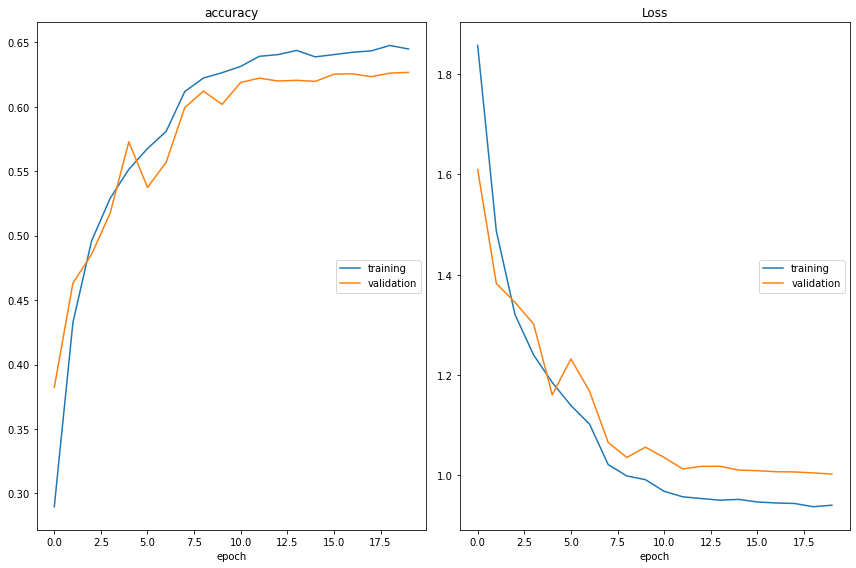

accuracy
	training         	 (min:    0.290, max:    0.648, cur:    0.645)
	validation       	 (min:    0.382, max:    0.627, cur:    0.627)
Loss
	training         	 (min:    0.937, max:    1.857, cur:    0.940)
	validation       	 (min:    1.002, max:    1.610, cur:    1.002)
528/528 [==============================] - 1057s 2s/step - loss: 0.9402 - accuracy: 0.6448 - val_loss: 1.0023 - val_accuracy: 0.6267 - lr: 1.0000e-05
Tiempo de entrenamiento: 05:33:30


In [18]:
# Medir el tiempo
%time  
start_time = time.time()

epochs = 20

# Tamaño de los datos entre el número de lotes
steps_per_epoch = train_generator.n//train_generator.batch_size  
validation_steps = validation_generator.n//validation_generator.batch_size

# --- Callbacks  --- #
# Ir reduciendo la learning rate para que sea más pequeña cerca al mínimo
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,     # Reducir la lr en 0.1
                              patience=2,     # No. de epochs en que no cambia
                              min_lr=0.00001, # Poner un límite inferior a la lr
                              mode='auto')    

# Guardar los pesos del modelo que tienen la mayor presición
checkpoint = ModelCheckpoint("model_weights.h5", 
                             monitor='val_accuracy',  # Basado en la validation accuracy
                             save_weights_only=True,  # El mejor modelo
                             mode='max',              # Máx. val accuracy
                             verbose=0)               # Imprimir

callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

# Entrenar el modelo
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

training_time = time.time() - start_time
print("Tiempo de entrenamiento:", time.strftime("%H:%M:%S", time.gmtime(training_time)))

## Guardar el modelo como JSON String

In [19]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Cargar el modelo

In [20]:
from tensorflow.keras.models import model_from_json

# Cargar la arquitectura del modelo desde el archivo JSON
with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)

# Cargar los pesos en el modelo
model.load_weights('model_weights.h5')

# Compilar el modelo (si es necesario)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Métricas del modelo

- Precision: Es la proporción de verdaderos positivos (instancias correctamente clasificadas) respecto a todas las instancias clasificadas en esa clase. Cuanto más alto sea este valor, mejor es el modelo para predecir correctamente esa clase.

- Recall: Es la proporción de verdaderos positivos respecto a todas las instancias reales de esa clase. Cuanto más alto sea este valor, mejor es el modelo para capturar todas las instancias de esa clase.

- F1-score: Es una medida de la precisión general del modelo, que combina tanto la precision como el recall en un solo valor. Cuanto más alto sea este valor, mejor es el rendimiento del modelo en esa clase.

- Support: Es el número de instancias reales de esa clase en el conjunto de datos.

El accuracy (exactitud) general del modelo es del 63%, lo que significa que el modelo clasifica correctamente el 63% de todas las instancias en el conjunto de datos.

El macro avg (promedio macro) y el weighted avg (promedio ponderado) son medidas generales del desempeño del modelo, que tienen en cuenta el desempeño en todas las clases. El macro avg calcula el promedio de las métricas para cada clase, sin considerar el desequilibrio de las clases. El weighted avg calcula el promedio ponderado de las métricas teniendo en cuenta el número de instancias en cada clase.

In [21]:
from sklearn.metrics import classification_report
emociones = {v: k for k, v in validation_generator.class_indices.items()}

# Obtener las predicciones del modelo en el conjunto de prueba
test_predictions = model.predict(validation_generator)

# Obtener las etiquetas verdaderas del conjunto de prueba
true_labels = validation_generator.classes

# Convertir las predicciones en etiquetas predichas
predicted_labels = np.argmax(test_predictions, axis=1)

# Calcular el classification report para métricas por clase
report = classification_report(true_labels, predicted_labels)

print(report)
print(emociones)

57/57 [==============================] - 27s 472ms/step
              precision    recall  f1-score   support

           0       0.36      0.45      0.40        55
           1       0.57      0.52      0.54       491
           2       0.85      0.83      0.84       879
           3       0.51      0.28      0.36       528
           4       0.57      0.68      0.62       626
           5       0.71      0.79      0.75       416
           6       0.47      0.57      0.52       594

    accuracy                           0.63      3589
   macro avg       0.58      0.59      0.58      3589
weighted avg       0.63      0.63      0.62      3589

{0: 'Asco', 1: 'Enojado', 2: 'Feliz', 3: 'Miedo', 4: 'Neutral', 5: 'Sorpresa', 6: 'Triste'}


In [22]:
emociones.values()

dict_values(['Asco', 'Enojado', 'Feliz', 'Miedo', 'Neutral', 'Sorpresa', 'Triste'])

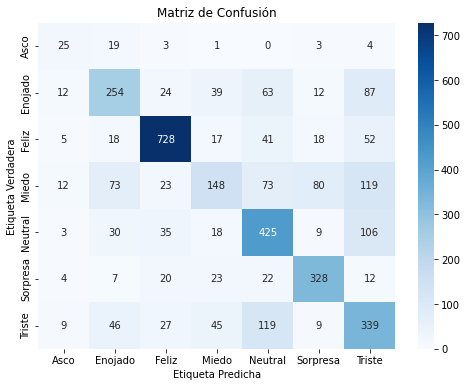

In [26]:
from sklearn.metrics import confusion_matrix

# Crear la matriz de confusión
cm = confusion_matrix(true_labels, predicted_labels)
labels = list(validation_generator.class_indices.keys())

# Crear el mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

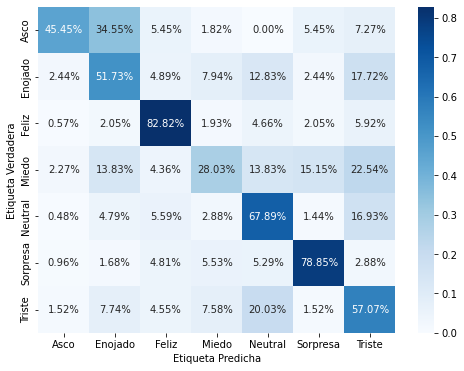

In [27]:
# Calcular la matriz de confusión
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Calcular los porcentajes de la matriz de confusión
confusion_mat_norm = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

# Crear la figura y el gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_norm, annot=True, cmap='Blues', fmt='.2%', xticklabels=labels, yticklabels=labels)

# Configurar las etiquetas de los ejes
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')

# Mostrar el gráfico
plt.show()

### Pruebas 

1/1 [==============================] - 0s 32ms/step


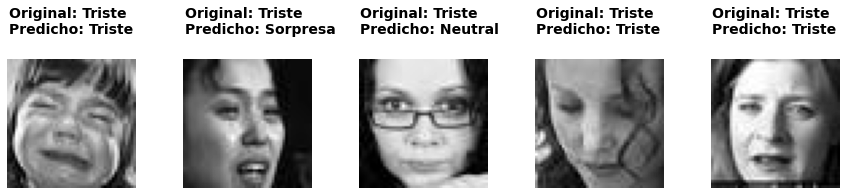

In [30]:
# Obtener las imágenes de la emoción "sad" desde el conjunto de validación
emotion_label = 'Triste'
emotion_index = list(emociones.keys())[list(emociones.values()).index(emotion_label)]
indices = np.where(validation_generator.labels == emotion_index)[0][-5:]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))

for i, ax in enumerate(axes):
    index = indices[i]
    image = validation_generator._get_batches_of_transformed_samples([index])[0][0]
    ax.imshow(image, cmap='gray')
    ax.axis('off')

    # Etiqueta original
    original_label = emociones[emotion_index]
    image = np.expand_dims(image, axis=0)  # Añadir dimensión de lote
    predicted_label = emociones[np.argmax(model.predict(image))]
    ax.text(0, -10, f'Original: {original_label} \nPredicho: {predicted_label}', color='black', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 31ms/step


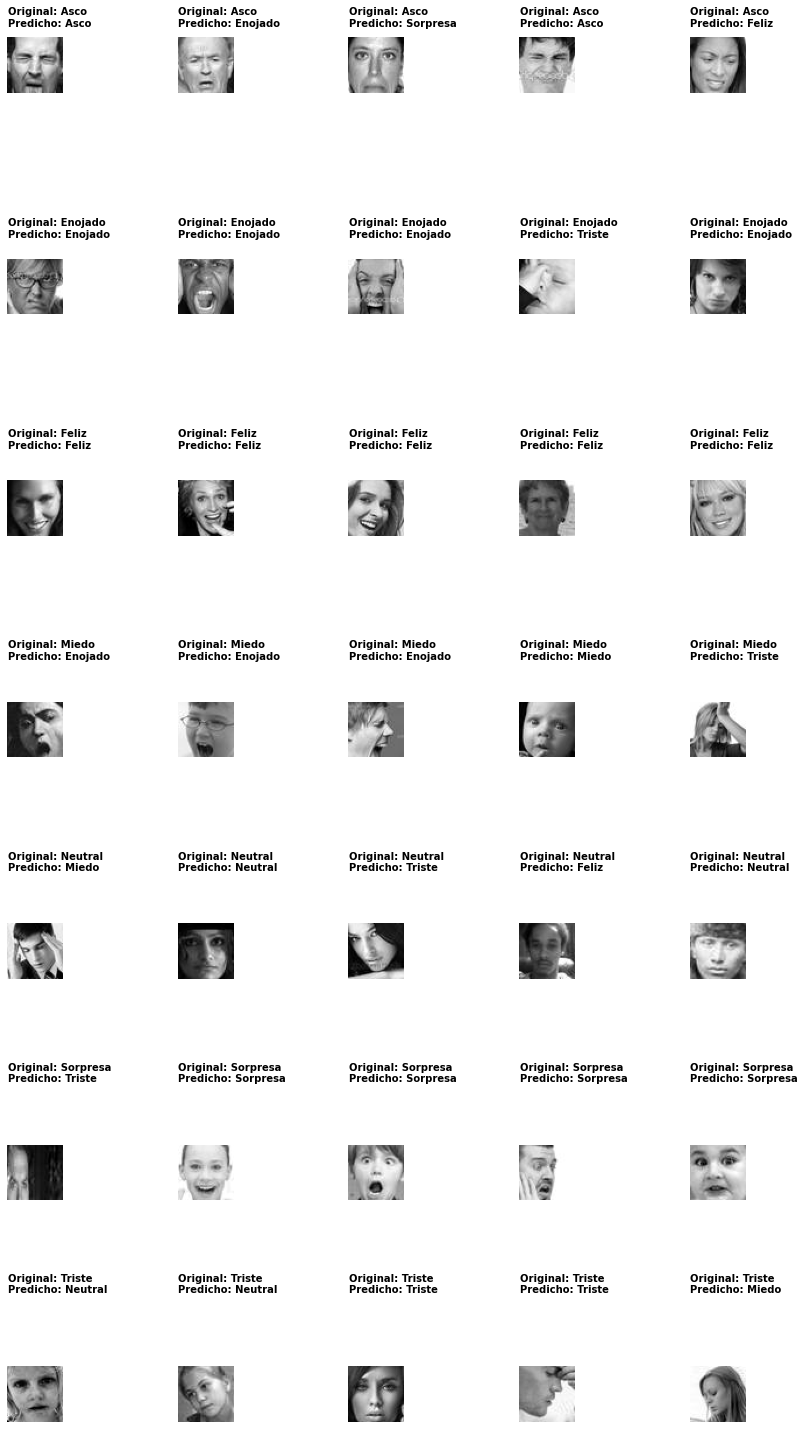

In [29]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(12, 20))

for i in range(7):  # Iterar sobre las emociones
    emotion_index = i
    indices = np.where(validation_generator.labels == emotion_index)[0][:5]

    for j, ax in enumerate(axes[i]):
        index = indices[j]
        image = validation_generator._get_batches_of_transformed_samples([index])[0][0]
        ax.imshow(image, cmap='gray')
        ax.axis('off')

        # Etiqueta original
        original_label = emociones[emotion_index]
        image = np.expand_dims(image, axis=0)  # Añadir dimensión de lote
        predicted_label = emociones[np.argmax(model.predict(image))]
        ax.text(0, -10 - i * 9, f'Original: {original_label} \nPredicho: {predicted_label}', color='black', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()